In [21]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
# import matplotlib.pyplot as plt

# Project paths
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, project_root)

from src.model import load_model
from src.detection import slide_window, detect_vehicles
#Evaluation detection library
# from src.detection import evaluate_image, aggregate_results
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [22]:
# === Load model & demo image ===
model, scaler = load_model(
    model_path="../model/vehicle_svm_model.pkl",
    scaler_path="../model/feature_scaler.pkl"
)

img_path = "../Data/vehicle/cars/car177.jpg"
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(img_path)

In [23]:
# === Slide windows visualization ===
windows = slide_window(img.shape, window_size=(128,128), stride=16)
print(f"Generated {len(windows)} sliding windows.")

Generated 6441 sliding windows.


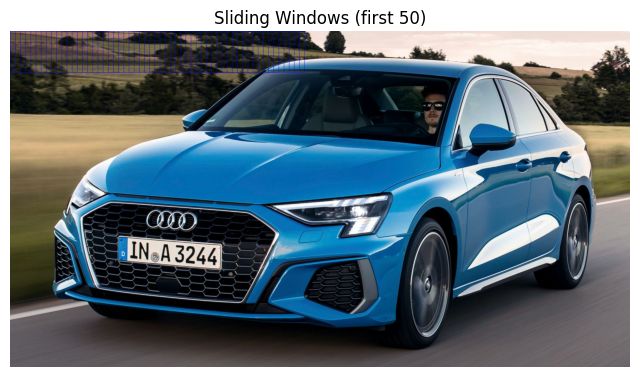

In [24]:
vis = img.copy()
for (x1, y1, x2, y2) in windows[:50]:
    cv2.rectangle(vis, (x1,y1), (x2,y2), (255,0,0), 1)

plt.figure(figsize=(8,6))
plt.title("Sliding Windows (first 50)")
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [ ]:
# === Run detection & visualize results ===
boxes = detect_vehicles(img, model, scaler,
                        window_size=(128,128),
                        stride=16,
                        threshold=1.0)
print(f"After NMS: {len(boxes)} boxes detected.")

In [ ]:
class_names = {
    "cars": "Car",
    "trucks": "Truck",
    "motorcycle": "Motorbike",
    "threewheel": "ThreeWheel",
    "non-vehicle": "Background"
}

vis2 = img.copy()
for (x1, y1, x2, y2, label, score) in boxes:
    cv2.rectangle(vis2, (x1, y1), (x2, y2), (0,255,0), 2)
    text = f"{class_names.get(label,label)} {score*100:.1f}%"
    cv2.putText(vis2, text, (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

plt.figure(figsize=(10,8))
plt.title("Vehicle Detections with Labels & Confidence")
plt.imshow(cv2.cvtColor(vis2, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

**Detection pipeline**

 Use slide_window() to generate search regions

 Extract HOG features for each window

 Use your trained SVM model to predict each window

 Mark windows where SVM says “vehicle”

 Apply Non-Maximum Suppression (NMS) to remove overlapping detections

**Detection Evaluation**

- Quantify how well your detector is performing on held-out images.

- Compute precision, recall (and if you like, F1 score or mAP) at a chosen IoU threshold (e.g. 0.5).

- Visualize true positives, false positives, and false negatives to spot failure modes.

In [ ]:
# # At the very top of your notebook, run this once:
# %matplotlib inline

# # Then in your annotation cell:

# import os
# import glob
# import xml.etree.ElementTree as ET
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# from PIL import Image

# # 1) CONFIGURE THESE PATHS
# project_root   = os.getcwd()  # or wherever your Vehicle-Detection folder is
# IMG_DIR        = os.path.join(project_root, "processed_images", "data-split", "test_images")
# ANNOT_DIR      = os.path.join(IMG_DIR, "Annotations")
# os.makedirs(ANNOT_DIR, exist_ok=True)

# # 2) XML-saving helper
# def save_pascal_xml(img_path, boxes, labels, save_path):
#     img = Image.open(img_path)
#     w, h = img.size
#     ann = ET.Element("annotation")
#     ET.SubElement(ann, "folder"  ).text = os.path.basename(os.path.dirname(img_path))
#     ET.SubElement(ann, "filename").text = os.path.basename(img_path)
#     size = ET.SubElement(ann, "size")
#     ET.SubElement(size, "width" ).text = str(w)
#     ET.SubElement(size, "height").text = str(h)
#     ET.SubElement(size, "depth" ).text = str(len(img.getbands()))
#     for (x1,y1,x2,y2), lbl in zip(boxes, labels):
#         obj = ET.SubElement(ann, "object")
#         ET.SubElement(obj, "name").text = lbl
#         bnd = ET.SubElement(obj, "bndbox")
#         ET.SubElement(bnd, "xmin").text = str(int(x1))
#         ET.SubElement(bnd, "ymin").text = str(int(y1))
#         ET.SubElement(bnd, "xmax").text = str(int(x2))
#         ET.SubElement(bnd, "ymax").text = str(int(y2))
#     tree = ET.ElementTree(ann)
#     tree.write(save_path)

# # 3) Main annotation loop
# for img_path in sorted(glob.glob(os.path.join(IMG_DIR, "*.*"))):
#     img_name = os.path.basename(img_path)
#     xml_path = os.path.join(ANNOT_DIR, img_name.rsplit(".", 1)[0] + ".xml")
#     if os.path.exists(xml_path):
#         print(f"✓ Skipping {img_name}, already annotated.")
#         continue

#     print(f"\nAnnotating: {img_name}")
#     img = plt.imread(img_path)
#     fig, ax = plt.subplots(1, figsize=(8, 6))
#     ax.imshow(img)
#     ax.set_title("Enter box coordinates (x1,y1,x2,y2) when prompted")

#     # **Fixed initialization**:
#     boxes = []
#     labels = []

#     while True:
#         try:
#             x1, y1 = map(int, input("Top-left (x1,y1): ").split(","))
#             x2, y2 = map(int, input("Bottom-right (x2,y2): ").split(","))
#         except ValueError:
#             print("Invalid input. Use format x1,y1")
#             continue

#         # draw the box
#         rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
#                                  linewidth=2, edgecolor='r', facecolor='none')
#         ax.add_patch(rect)
#         plt.draw()

#         lbl = input("Label for this box: ")
#         boxes.append((x1, y1, x2, y2))
#         labels.append(lbl)

#         cont = input("Add another box? [y/n]: ")
#         if cont.lower() != 'y':
#             break

#     plt.close(fig)

#     if boxes:
#         save_pascal_xml(img_path, boxes, labels, xml_path)
#         print(f"✅ Saved annotation: {xml_path}")
#     else:
#         print(f"⚠️ No boxes entered for {img_name}, skipping save.")

In [ ]:
# ## import os
# import glob
# import cv2
# import xml.etree.ElementTree as ET
# import numpy as np
# from src.model import load_model
# from src.detection import (
#     detect_vehicles,
#     evaluate_image,
#     aggregate_results
# )

# # 1) Find project root (where Data/vehicle lives)
# def find_project_root():
#     cur = os.path.abspath(os.getcwd())
#     while cur != os.path.dirname(cur):
#         if os.path.isdir(os.path.join(cur, "Data", "vehicle")):
#             return cur
#         cur = os.path.dirname(cur)
#     raise RuntimeError("Project root not found")

# project_root = find_project_root()

# # 2) Paths to your test images and annotations
# TEST_IMG_DIR    = os.path.join(project_root, "processed_images", "data-split", "test_images")
# ANNOT_DIR       = os.path.join(project_root, "processed_images", "data-split", "test", "Annotations")
# # (If you saved XMLs directly under data-split/test_images, adjust accordingly)

# # 3) Load model & scaler
# model, scaler = load_model()

# # 4) Prepare to accumulate results
# all_results = []

# # 5) Loop through each test image
# for img_name in sorted(os.listdir(TEST_IMG_DIR)):
#     img_path = os.path.join(TEST_IMG_DIR, img_name)
#     img = cv2.imread(img_path)
#     if img is None:
#         print(f"⚠️ Could not read image {img_name}, skipping")
#         continue

#     # 5a) Predict detections
#     preds = detect_vehicles(
#         image=img,
#         model=model,
#         scaler=scaler,
#         window_size=(128,128),
#         stride=16,
#         threshold=1.0
#     )
#     # preds is list of (x1,y1,x2,y2,label,score)

#     # 5b) Load ground‐truth from XML
#     xml_path = os.path.join(
#         ANNOT_DIR,
#         os.path.splitext(img_name)[0] + ".xml"
#     )
#     if not os.path.exists(xml_path):
#         print(f"⚠️ Missing annotation for {img_name}, skipping")
#         continue

#     tree = ET.parse(xml_path)
#     root = tree.getroot()
#     gts = []
#     for obj in root.findall("object"):
#         cls = obj.find("name").text
#         bnd = obj.find("bndbox")
#         x1 = int(bnd.find("xmin").text)
#         y1 = int(bnd.find("ymin").text)
#         x2 = int(bnd.find("xmax").text)
#         y2 = int(bnd.find("ymax").text)
#         gts.append((x1, y1, x2, y2, cls))

#     # 5c) Evaluate this image
#     tp, fp, fn = evaluate_image(preds, gts, iou_thresh=0.5)
#     all_results.append((tp, fp, fn))

# # 6) Aggregate overall precision, recall, F1
# precision, recall, f1 = aggregate_results(all_results)

# print("=== Detection Evaluation ===")
# print(f"Precision: {precision:.3f}")
# print(f"Recall:    {recall:.3f}")
# print(f"F1-score:  {f1:.3f}")

In [4]:
# ─── Cell 1: Setup & Imports ─────────────────────────────────────
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, project_root)

import numpy as np
from sklearn.preprocessing import StandardScaler
from src.model import load_model
from src.detection import (
    load_test_data,
    evaluate_classification,
    plot_confusion_matrix
)

In [5]:
# ─── Cell 2: Paths & Class Names ─────────────────────────────────
FEATURE_PATH = "../Data/X_test.npy"    # your test‐set features
LABEL_PATH   = "../Data/y_test.npy"    # your test‐set labels
CLASS_NAMES  = ["cars", "trucks", "threewheel", "motorcycle", "non-vehicle"]

In [6]:
# ─── Cell 3: Load Data ───────────────────────────────────────────
X_test, y_test = load_test_data(FEATURE_PATH, LABEL_PATH)
print(f"Loaded X_test shape: {X_test.shape}")
print(f"Loaded y_test shape: {y_test.shape}")

Loaded X_test shape: (150, 8100)
Loaded y_test shape: (150,)


In [7]:
# ─── Cell 4: Load Model & Scaler ─────────────────────────────────
model, scaler = load_model(
    model_path="../model/vehicle_svm_model.pkl",
    scaler_path="../model/feature_scaler.pkl"
)

In [8]:
# (If you didn’t save a separate test‐scaler, you can refit on train+val here; 
#  but typically you saved the scaler when training.)

# ─── Cell 5: Evaluate ────────────────────────────────────────────
metrics = evaluate_classification(model, scaler, X_test, y_test)
print(f"Accuracy : {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall   : {metrics['recall']:.4f}")
print(f"F1-score : {metrics['f1']:.4f}")

print("\nClassification Report:\n")
print(metrics["classification_report"])

Accuracy : 0.9400
Precision: 0.9412
Recall   : 0.9400
F1-score : 0.9403

Classification Report:

              precision    recall  f1-score   support

        cars       0.88      0.93      0.90        30
  motorcycle       0.97      0.93      0.95        30
  nonvehicle       0.93      0.93      0.93        30
  threewheel       0.97      0.93      0.95        30
      trucks       0.97      0.97      0.97        30

    accuracy                           0.94       150
   macro avg       0.94      0.94      0.94       150
weighted avg       0.94      0.94      0.94       150



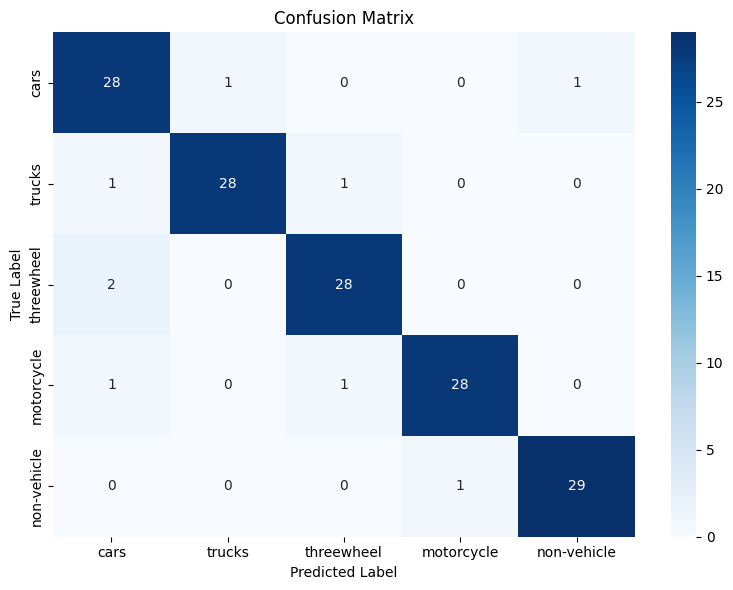

In [20]:
# ─── Cell 6: Confusion Matrix ───────────────────────────────────
cm = metrics["confusion_matrix"]

# Plot confusion matrix using seaborn heatmap (the refined version)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
# # 6) Plot confusion matrix
# labels = np.unique(y_test)  # ensure classes appear in order
# plt.figure(figsize=(8, 6))
# sns.heatmap(
#     cm,
#     annot=True,
#     fmt="d",
#     cmap="Blues",
#     xticklabels=labels,
#     yticklabels=labels
# )
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()